In [4]:
import os
import pandas as pd
import glob
import cv2

import torch

import pydicom
from pydicom.pixel_data_handlers import apply_windowing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from libs.dali_helper import (J2kIterator, j2k_decode_pipeline, j2k_postprocessing, JllIterator, 
                              jll_process_pipeline, jll_postprocessing, CustomDALIGenericIterator)
from libs.image_processing import to_3_channels, get_yolo, roi_extraction_yolov5, show_img_and_roi, crop_img, resize_and_pad, check_mkdir

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
IMG_DIR = "/home/data4/share/rsna-breast-cancer-detection/train_images"

In [6]:
df = pd.read_csv("/home/data4/share/rsna-breast-cancer-detection/train.csv")
df['dcm'] = IMG_DIR + '/' + df.patient_id.astype(str) + '/' + df.image_id.astype(str) + '.dcm'
df_j2k, df_jll = df[df["site_id"]==2].reset_index(drop=True), df[df["site_id"]==1].reset_index(drop=True)
print('j2k:', len(df_j2k), 'jll:', len(df_jll))

j2k: 25187 jll: 29519


## ROI Extraction with YOLOv5 and CV2

In [7]:
if not os.path.isdir('./yolov5'):
    !git clone https://github.com/ultralytics/yolov5 

In [8]:
roi_model = get_yolo()

YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.8.19 torch-1.13.1+cu116 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [11]:
j2k_it = J2kIterator(df=df[df["patient_id"]==10006], batch_size=4, img_dir=IMG_DIR)
j2k_pipe = j2k_decode_pipeline(j2k_it, width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                             py_num_workers=1, exec_async=False, exec_pipelined=False)
j2k_pipe.build()
j2k_out = j2k_pipe.run()

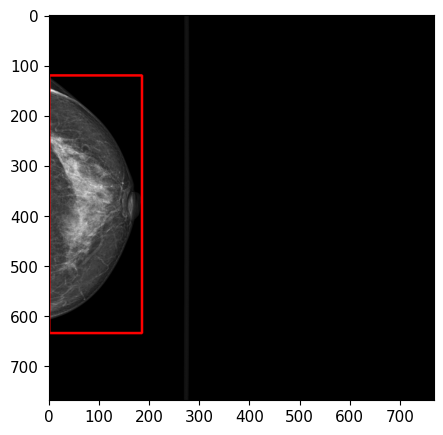

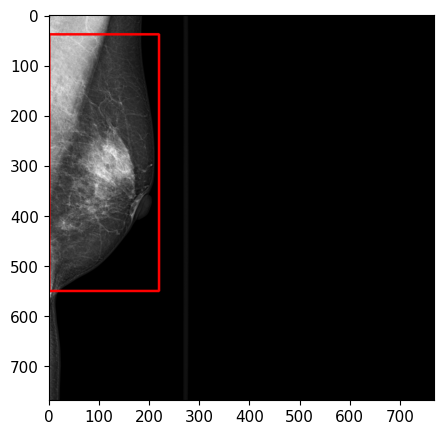

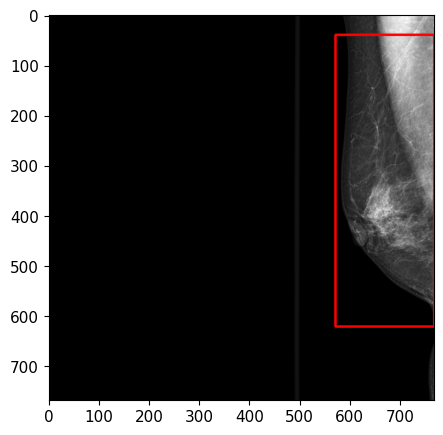

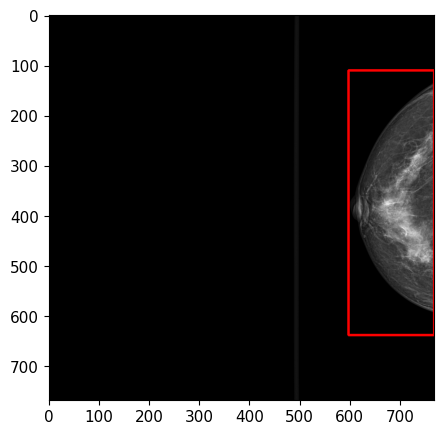

In [12]:
for i in range(len(j2k_out[0])):
    j2k_img, j2k_img_window = j2k_postprocessing(j2k_out, i)
    roi = roi_extraction_yolov5(roi_model, j2k_img)
    show_img_and_roi(j2k_img_window, roi)

In [14]:
jll_it = JllIterator(df=df[df["patient_id"]==10038], batch_size=4, img_dir=IMG_DIR)
jll_pipe = jll_process_pipeline(jll_it, width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                              py_num_workers=1, exec_async=False, exec_pipelined=False)
jll_pipe.build()
jll_out = jll_pipe.run()

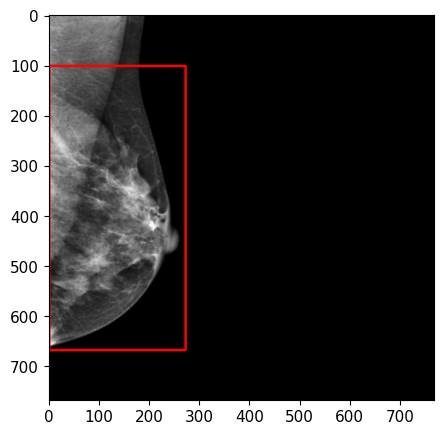

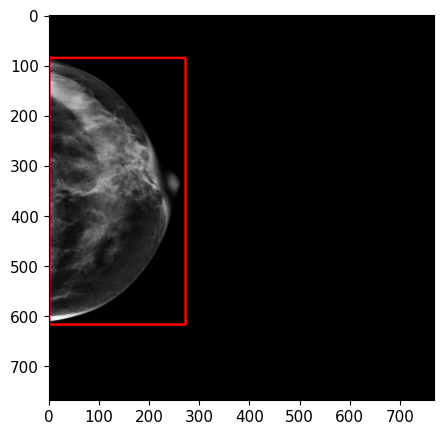

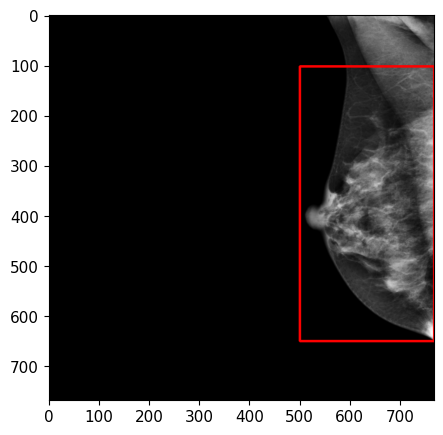

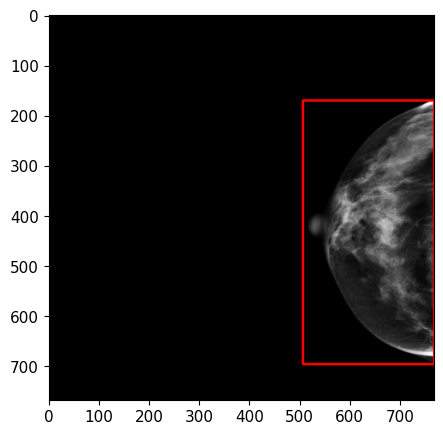

In [15]:
for i in range(len(jll_out[0])):
    jll_img, jll_img_window = jll_postprocessing(jll_out, i)
    roi = roi_extraction_yolov5(roi_model, jll_img)
    show_img_and_roi(jll_img_window, roi)

### Resize and Padding

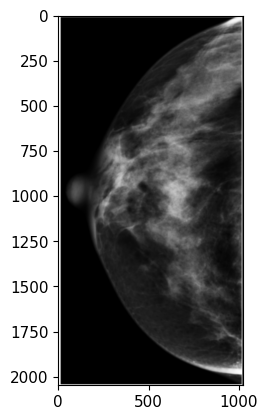

In [16]:
test_crop = crop_img(jll_img_window, roi)
rp_img = resize_and_pad(test_crop)
plt.imshow(rp_img, cmap='bone')
plt.show()

## Save Cropped Images

In [5]:
roi_model = get_yolo()

YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.8.19 torch-1.13.1+cu116 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [17]:
df_j2k = df_j2k[:320]
j2k_it = J2kIterator(df_j2k, batch_size=32, img_dir="/home/data4/share/rsna-breast-cancer-detection/train_images")
j2k_pipe = j2k_decode_pipeline(j2k_it, width=768, height=768, batch_size=32, num_threads=2, device_id=0, 
                               py_num_workers=4, exec_async=False, exec_pipelined=False)
j2k_loader = CustomDALIGenericIterator(yolo_model=roi_model, length=len(df_j2k), save_img=True, pipelines=[j2k_pipe])

In [18]:
# save cropped j2k images
for i, b in enumerate(j2k_loader):
    print(f"batch {i} complete")

0
1
2
3
4
5
6
7
8
9


In [19]:
df_jll = df_jll[:320]
jll_it = JllIterator(df_jll, batch_size=32, img_dir="/home/data4/share/rsna-breast-cancer-detection/train_images")
jll_pipe = jll_process_pipeline(jll_it, width=768, height=768, batch_size=32, num_threads=2, device_id=0, 
                                py_num_workers=4, exec_async=False, exec_pipelined=False)
jll_loader = CustomDALIGenericIterator(yolo_model=roi_model, length=len(df_jll), save_img=True, pipelines=[jll_pipe])

In [20]:
# save cropped jll images
for i, b in enumerate(jll_loader):
    print(f"batch {i} complete")

0
1
2
3
4
5
6
7
8
9


In [454]:
# save cropped j2k images
"""
for p_id in tqdm(df_j2k["patient_id"].unique()):
    df_subset = df[df["patient_id"]==p_id]
    subset_size = len(df_subset)
    j2k_it = J2kIterator(df=df_subset, batch_size=subset_size, img_dir=Config["dcm_dir"])
    j2k_pipe = j2k_decode_pipeline(j2k_it, width=768, height=768, batch_size=subset_size, num_threads=2, device_id=0, 
                                   py_num_workers=1, exec_async=False, exec_pipelined=False)
    j2k_pipe.build()
    j2k_out = j2k_pipe.run()
    for i in range(len(j2k_out[0])):
        j2k_img, j2k_img_window = j2k_postprocessing(j2k_out, i)
        try:
            roi = roi_extraction_yolov5(roi_model, j2k_img)
            j2k_img_crop = crop_img(j2k_img_window, roi)
        except:
            try:
                j2k_img_gray = cv2.cvtColor(j2k_img, cv2.COLOR_BGR2GRAY)
                roi = roi_extraction_cv2(j2k_img_gray)
                j2k_img_crop = crop_img(j2k_img_window, roi)
                print("using cv2 for cropping")
            except:
                j2k_img_crop = j2k_img
                print("cropping failed...")
        j2k_img_pad = resize_and_pad(j2k_img_crop)
        save_path = f"/home/FanHuang247817/train_images_png2_test/{p_id}/{img_id}.png"
        check_mkdir(save_path)
        cv2.imwrite(save_path, j2k_img_pad)
"""

  0%|▏                                                                                                                                                     | 7/6095 [00:05<1:24:49,  1.20it/s]

cropping failed...


  5%|███████▌                                                                                                                                            | 311/6095 [04:41<1:30:15,  1.07it/s]

cropping failed...


  5%|███████▋                                                                                                                                            | 318/6095 [04:47<1:31:30,  1.05it/s]

cropping failed...


 10%|██████████████▍                                                                                                                                     | 594/6095 [08:59<1:19:19,  1.16it/s]

cropping failed...


 10%|███████████████▍                                                                                                                                    | 634/6095 [09:36<1:23:17,  1.09it/s]

cropping failed...


 11%|████████████████                                                                                                                                    | 661/6095 [10:01<1:33:02,  1.03s/it]

cropping failed...


 11%|████████████████▊                                                                                                                                   | 694/6095 [10:30<1:22:13,  1.09it/s]

cropping failed...
cropping failed...


 11%|████████████████▉                                                                                                                                   | 695/6095 [10:31<1:15:14,  1.20it/s]

cropping failed...


 15%|██████████████████████▌                                                                                                                             | 929/6095 [14:06<1:14:54,  1.15it/s]

cropping failed...


 17%|█████████████████████████▋                                                                                                                         | 1063/6095 [16:09<1:11:30,  1.17it/s]

cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1068/6095 [16:14<1:10:47,  1.18it/s]

cropping failed...
cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1069/6095 [16:14<1:05:22,  1.28it/s]

cropping failed...
cropping failed...


 23%|█████████████████████████████████▌                                                                                                                 | 1394/6095 [21:14<1:18:56,  1.01s/it]

cropping failed...


 23%|██████████████████████████████████                                                                                                                 | 1413/6095 [21:31<1:05:45,  1.19it/s]

cropping failed...
cropping failed...


 23%|██████████████████████████████████▎                                                                                                                | 1424/6095 [21:41<1:10:35,  1.10it/s]

cropping failed...
cropping failed...


 27%|████████████████████████████████████████▎                                                                                                          | 1670/6095 [25:32<1:05:57,  1.12it/s]

cropping failed...


 30%|███████████████████████████████████████████▉                                                                                                       | 1822/6095 [27:55<1:04:29,  1.10it/s]

cropping failed...


 32%|██████████████████████████████████████████████▎                                                                                                    | 1922/6095 [29:31<1:12:53,  1.05s/it]

cropping failed...


 34%|█████████████████████████████████████████████████▍                                                                                                 | 2050/6095 [31:30<1:05:31,  1.03it/s]

cropping failed...
cropping failed...


 34%|██████████████████████████████████████████████████▍                                                                                                | 2091/6095 [32:08<1:05:28,  1.02it/s]

cropping failed...
cropping failed...


 34%|███████████████████████████████████████████████████▏                                                                                                 | 2092/6095 [32:09<59:15,  1.13it/s]

cropping failed...


 36%|██████████████████████████████████████████████████████▏                                                                                              | 2215/6095 [34:04<55:54,  1.16it/s]

cropping failed...


 38%|███████████████████████████████████████████████████████▏                                                                                           | 2289/6095 [35:14<1:00:04,  1.06it/s]

cropping failed...


 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 2608/6095 [40:11<51:21,  1.13it/s]

cropping failed...


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 2997/6095 [46:10<45:09,  1.14it/s]

cropping failed...
cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 3111/6095 [47:54<43:30,  1.14it/s]

cropping failed...
cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 3112/6095 [47:55<43:39,  1.14it/s]

cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 3125/6095 [48:07<46:48,  1.06it/s]

cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 3126/6095 [48:07<42:53,  1.15it/s]

cropping failed...


 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 3191/6095 [49:07<44:22,  1.09it/s]

cropping failed...


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 3208/6095 [49:22<43:30,  1.11it/s]

cropping failed...
cropping failed...


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 3209/6095 [49:23<39:34,  1.22it/s]

cropping failed...
cropping failed...


 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 3237/6095 [49:49<45:07,  1.06it/s]

cropping failed...


 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 3269/6095 [50:17<41:23,  1.14it/s]

cropping failed...


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3394/6095 [52:11<41:42,  1.08it/s]

cropping failed...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3667/6095 [56:25<39:51,  1.02it/s]

cropping failed...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3846/6095 [59:09<32:45,  1.14it/s]

cropping failed...


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4038/6095 [1:02:09<32:37,  1.05it/s]

cropping failed...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4249/6095 [1:05:24<29:20,  1.05it/s]

cropping failed...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4342/6095 [1:06:50<25:57,  1.13it/s]

cropping failed...
cropping failed...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4343/6095 [1:06:51<24:09,  1.21it/s]

cropping failed...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4627/6095 [1:11:12<22:39,  1.08it/s]

cropping failed...


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4646/6095 [1:11:29<20:49,  1.16it/s]

cropping failed...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4763/6095 [1:13:19<20:35,  1.08it/s]

cropping failed...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5052/6095 [1:17:45<15:19,  1.13it/s]

cropping failed...
cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5111/6095 [1:18:39<14:48,  1.11it/s]

cropping failed...
cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5112/6095 [1:18:40<13:24,  1.22it/s]

cropping failed...
cropping failed...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 5142/6095 [1:19:07<14:05,  1.13it/s]

cropping failed...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5168/6095 [1:19:32<16:08,  1.04s/it]

cropping failed...
cropping failed...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5268/6095 [1:21:03<12:17,  1.12it/s]

cropping failed...
cropping failed...
cropping failed...
cropping failed...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5368/6095 [1:22:37<11:38,  1.04it/s]

cropping failed...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5594/6095 [1:26:05<07:17,  1.14it/s]

cropping failed...


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5643/6095 [1:26:49<06:23,  1.18it/s]

cropping failed...


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5646/6095 [1:26:51<06:19,  1.18it/s]

cropping failed...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5769/6095 [1:28:45<04:59,  1.09it/s]

cropping failed...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5874/6095 [1:30:20<03:27,  1.07it/s]

cropping failed...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5875/6095 [1:30:21<03:24,  1.07it/s]

cropping failed...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5978/6095 [1:31:55<01:44,  1.12it/s]

cropping failed...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6095/6095 [1:33:42<00:00,  1.08it/s]


In [455]:
# save cropped jll images
"""
for p_id in tqdm(df_jpg["patient_id"].unique()):
    df_subset = df[df["patient_id"]==p_id]
    subset_size = len(df_subset)
    JpgIter = JpgIterator(df=df_subset, batch_size=subset_size, img_dir=Config["dcm_dir"])
    pipe = jpg_process_pipeline(width=768, height=768, batch_size=subset_size, num_threads=2, device_id=0, 
                               py_num_workers=1, exec_async=False, exec_pipelined=False)
    pipe.build()
    jpg_out = pipe.run()
    for i in range(len(jpg_out[0])):
        jpg_img, jpg_img_window, img_id = jpg_pipe_postprocessing(jpg_out, i, p_id)
        try:
            roi = roi_extraction_yolov5(roi_model, jpg_img)
            jpg_img_crop = crop_img(jpg_img_window, roi)
        except:
            try:
                jpg_img_gray = cv2.cvtColor(jpg_img, cv2.COLOR_BGR2GRAY)
                roi = roi_extraction_cv2(jpg_img_gray)
                jpg_img_crop = crop_img(jpg_img_window, roi)
                print("using cv2 for cropping")
            except:
                jpg_img_crop = jpg_img
                print("cropping failed...")
        jpg_img_pad = resize_and_pad(jpg_img_crop)
        save_path = f"/home/FanHuang247817/train_images_png2/{p_id}/{img_id}.png"
        check_mkdir(save_path)
        cv2.imwrite(save_path, jpg_img_pad)
"""

  4%|█████▋                                                                                                                                              | 222/5818 [06:46<3:39:04,  2.35s/it]

cropping failed...


  5%|████████                                                                                                                                            | 316/5818 [09:28<2:36:19,  1.70s/it]

cropping failed...


  9%|████████████▋                                                                                                                                       | 501/5818 [14:56<2:41:54,  1.83s/it]

cropping failed...


  9%|█████████████                                                                                                                                       | 515/5818 [15:22<3:12:07,  2.17s/it]

cropping failed...


 11%|████████████████                                                                                                                                    | 632/5818 [18:48<2:34:03,  1.78s/it]

cropping failed...


 11%|████████████████▎                                                                                                                                   | 641/5818 [19:05<3:04:29,  2.14s/it]

cropping failed...


 12%|█████████████████▌                                                                                                                                  | 688/5818 [20:32<2:49:21,  1.98s/it]

cropping failed...


 13%|███████████████████▋                                                                                                                                | 776/5818 [23:16<1:50:57,  1.32s/it]

cropping failed...


 16%|███████████████████████                                                                                                                             | 908/5818 [27:14<2:21:25,  1.73s/it]

cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1021/5818 [30:34<2:12:45,  1.66s/it]

cropping failed...


 18%|███████████████████████████                                                                                                                        | 1069/5818 [32:03<2:41:55,  2.05s/it]

cropping failed...


 20%|█████████████████████████████▍                                                                                                                     | 1164/5818 [34:59<2:03:26,  1.59s/it]

cropping failed...


 21%|███████████████████████████████▎                                                                                                                   | 1237/5818 [37:13<2:04:55,  1.64s/it]

cropping failed...


 22%|███████████████████████████████▊                                                                                                                   | 1258/5818 [37:48<1:38:43,  1.30s/it]

cropping failed...


 23%|█████████████████████████████████▌                                                                                                                 | 1328/5818 [39:55<2:19:29,  1.86s/it]

cropping failed...


 25%|████████████████████████████████████▉                                                                                                              | 1464/5818 [43:59<1:44:59,  1.45s/it]

cropping failed...


 26%|██████████████████████████████████████▏                                                                                                            | 1513/5818 [45:30<2:38:36,  2.21s/it]

cropping failed...


 26%|██████████████████████████████████████▎                                                                                                            | 1518/5818 [45:38<1:55:55,  1.62s/it]

cropping failed...


 27%|██████████████████████████████████████▉                                                                                                            | 1543/5818 [46:21<1:59:41,  1.68s/it]

cropping failed...


 28%|████████████████████████████████████████▌                                                                                                          | 1603/5818 [48:07<1:42:26,  1.46s/it]

cropping failed...


 28%|█████████████████████████████████████████▋                                                                                                         | 1650/5818 [49:31<3:08:24,  2.71s/it]

cropping failed...


 28%|█████████████████████████████████████████▊                                                                                                         | 1655/5818 [49:44<2:41:12,  2.32s/it]

cropping failed...


 29%|██████████████████████████████████████████                                                                                                         | 1663/5818 [50:00<2:10:40,  1.89s/it]

cropping failed...


 29%|██████████████████████████████████████████▎                                                                                                        | 1673/5818 [50:17<1:57:22,  1.70s/it]

cropping failed...


 30%|███████████████████████████████████████████▉                                                                                                       | 1737/5818 [52:14<1:34:41,  1.39s/it]

cropping failed...


 31%|█████████████████████████████████████████████▊                                                                                                     | 1812/5818 [54:27<1:46:40,  1.60s/it]

cropping failed...


 32%|███████████████████████████████████████████████▋                                                                                                   | 1889/5818 [57:02<1:45:22,  1.61s/it]

cropping failed...


 34%|█████████████████████████████████████████████████▋                                                                                                 | 1968/5818 [59:24<1:35:27,  1.49s/it]

cropping failed...


 36%|████████████████████████████████████████████████████▌                                                                                            | 2109/5818 [1:03:41<1:47:36,  1.74s/it]

cropping failed...


 36%|████████████████████████████████████████████████████▋                                                                                            | 2113/5818 [1:03:47<1:28:16,  1.43s/it]

cropping failed...


 37%|█████████████████████████████████████████████████████▌                                                                                           | 2147/5818 [1:04:46<2:01:55,  1.99s/it]

cropping failed...


 38%|███████████████████████████████████████████████████████▊                                                                                         | 2237/5818 [1:07:30<1:37:30,  1.63s/it]

cropping failed...


 40%|█████████████████████████████████████████████████████████▊                                                                                       | 2322/5818 [1:10:09<2:00:04,  2.06s/it]

cropping failed...


 40%|█████████████████████████████████████████████████████████▉                                                                                       | 2327/5818 [1:10:15<1:14:43,  1.28s/it]

cropping failed...


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 2363/5818 [1:11:15<1:23:33,  1.45s/it]

cropping failed...


 41%|███████████████████████████████████████████████████████████▎                                                                                     | 2382/5818 [1:11:50<1:39:52,  1.74s/it]

cropping failed...


 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 2473/5818 [1:14:29<1:37:31,  1.75s/it]

cropping failed...


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 2479/5818 [1:14:37<1:27:42,  1.58s/it]

cropping failed...


 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 2524/5818 [1:15:58<2:16:56,  2.49s/it]

cropping failed...


 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 2646/5818 [1:19:38<1:17:55,  1.47s/it]

cropping failed...


 46%|█████████████████████████████████████████████████████████████████▉                                                                               | 2648/5818 [1:19:42<1:35:08,  1.80s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 2673/5818 [1:20:24<1:16:03,  1.45s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 2677/5818 [1:20:31<1:27:58,  1.68s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 2680/5818 [1:20:37<1:27:23,  1.67s/it]

cropping failed...


 47%|████████████████████████████████████████████████████████████████████                                                                             | 2730/5818 [1:22:06<1:26:50,  1.69s/it]

cropping failed...


 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 2762/5818 [1:23:01<1:12:10,  1.42s/it]

cropping failed...


 49%|███████████████████████████████████████████████████████████████████████▏                                                                         | 2854/5818 [1:25:48<1:08:24,  1.38s/it]

cropping failed...


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 2869/5818 [1:26:16<1:27:17,  1.78s/it]

cropping failed...


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 3120/5818 [1:34:21<1:33:55,  2.09s/it]

cropping failed...


 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 3139/5818 [1:34:52<1:06:18,  1.49s/it]

cropping failed...


 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 3212/5818 [1:37:05<1:03:20,  1.46s/it]

cropping failed...


 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 3315/5818 [1:40:25<1:50:10,  2.64s/it]

cropping failed...


 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 3328/5818 [1:40:47<1:08:02,  1.64s/it]

cropping failed...


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3418/5818 [1:43:34<1:11:28,  1.79s/it]

cropping failed...


 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3422/5818 [1:43:42<1:38:56,  2.48s/it]

cropping failed...


 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3475/5818 [1:45:30<1:14:12,  1.90s/it]

cropping failed...


 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3479/5818 [1:45:38<1:09:00,  1.77s/it]

cropping failed...


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3611/5818 [1:49:43<1:06:02,  1.80s/it]

cropping failed...


 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3631/5818 [1:50:22<52:34,  1.44s/it]

cropping failed...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3689/5818 [1:52:13<50:12,  1.42s/it]

cropping failed...


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3728/5818 [1:53:23<55:37,  1.60s/it]

cropping failed...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3791/5818 [1:55:15<49:09,  1.46s/it]

cropping failed...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3795/5818 [1:55:21<50:14,  1.49s/it]

cropping failed...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3915/5818 [1:58:47<47:52,  1.51s/it]

cropping failed...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3930/5818 [1:59:11<51:26,  1.63s/it]

cropping failed...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3957/5818 [1:59:57<49:43,  1.60s/it]

cropping failed...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3960/5818 [2:00:01<51:38,  1.67s/it]

cropping failed...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3971/5818 [2:00:22<49:59,  1.62s/it]

cropping failed...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3987/5818 [2:00:52<1:12:25,  2.37s/it]

cropping failed...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4009/5818 [2:01:35<1:00:06,  1.99s/it]

cropping failed...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4036/5818 [2:02:20<55:41,  1.88s/it]

cropping failed...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4054/5818 [2:02:52<1:00:47,  2.07s/it]

cropping failed...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4062/5818 [2:03:07<51:57,  1.78s/it]

cropping failed...


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4177/5818 [2:06:31<40:28,  1.48s/it]

cropping failed...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4225/5818 [2:08:04<38:50,  1.46s/it]

cropping failed...


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4253/5818 [2:08:54<41:52,  1.61s/it]

cropping failed...


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4296/5818 [2:10:12<44:19,  1.75s/it]

cropping failed...


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4323/5818 [2:10:57<42:02,  1.69s/it]

cropping failed...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4338/5818 [2:11:26<37:58,  1.54s/it]

cropping failed...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4377/5818 [2:12:33<44:53,  1.87s/it]

cropping failed...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4414/5818 [2:13:40<41:49,  1.79s/it]

cropping failed...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4607/5818 [2:19:19<29:19,  1.45s/it]

cropping failed...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4660/5818 [2:20:58<36:37,  1.90s/it]

cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4872/5818 [2:27:22<25:30,  1.62s/it]

cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4890/5818 [2:27:56<28:14,  1.83s/it]

cropping failed...


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4948/5818 [2:29:31<20:49,  1.44s/it]

cropping failed...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5045/5818 [2:32:36<22:26,  1.74s/it]

cropping failed...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5459/5818 [2:45:02<12:17,  2.05s/it]

cropping failed...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5520/5818 [2:46:53<08:42,  1.75s/it]

cropping failed...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5564/5818 [2:48:23<08:41,  2.05s/it]

cropping failed...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5566/5818 [2:48:27<07:30,  1.79s/it]

cropping failed...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5649/5818 [2:50:39<04:03,  1.44s/it]/tmp/ipykernel_43897/4017234273.py:2: RuntimeWarning: invalid value encountered in divide
  img = (img - img.min()) / (img.max() - img.min())
/tmp/ipykernel_43897/4017234273.py:14: RuntimeWarning: invalid value encountered in cast
  return img_3c.astype(np.uint8)
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5650/5818 [2:50:41<04:29,  1.61s/it]

cropping failed...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5666/5818 [2:51:08<04:16,  1.69s/it]

cropping failed...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5667/5818 [2:51:13<06:28,  2.57s/it]

cropping failed...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5818/5818 [2:55:49<00:00,  1.81s/it]
